In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle,glob
from MLutils import  diversity_heatmap, merge_pickles_pred_dicts, diversity_matrix
from sklearn.metrics import  accuracy_score, cohen_kappa_score

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [4]:
import pandas as pd

In [5]:
pickle_list = glob.glob('ml_predictions/*.pkl')

In [6]:
pickle_list

['ml_predictions/results_dict,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/CNN_test.pkl',
 'ml_predictions/results_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(1, 1),LSA100,.pkl',
 'ml_predictions/results_dict,trim=5,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/results_dict,lemmas,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(1, 1),LSA100,.pkl',
 'ml_predictions/results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/results_dict,trim=5,lemmas,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/results_dict,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100,.pkl',
 'ml_predictions/fasttext.pkl',
 'ml_predictions/results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=1,_ngrams=(1, 1),LSA100,.pkl',
 'ml_predictions/results_dict,trim=5,lemmas,Ru

In [7]:
# pickle_list = ['ml_predictions/CNN_test.pkl',
#               'ml_predictions/pipeline_testresults_dict,trim=5,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100,.pkl'
#               ]

In [8]:
results_dict = merge_pickles_pred_dicts(pickle_list, f1_threshold=0.5)

Merged 34 different model variations


In [9]:
# # remove fasttext because I still need to fix the dictionary
# del results_dict['fasttext_fasttext']

In [10]:
ml_models = results_dict.keys()
ml_models.sort()

In [11]:
ml_models

['CNN_test_CNN',
 'RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM',
 'fasttext_fasttext',
 'results_dict,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_rbf_C=500',
 'results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression',
 'results_dict,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_NeuralNet(10,10)',
 'results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,ShortDepPath,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,ShortDepPath,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,ShortDepPath,lemmas,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_LogisticRegression',
 'results_dict,ShortDepPath,lemmas,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngram

In [12]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

In [13]:
# run to determine whether dicts are ok

# for key in results_dict.keys():
#     print key
#     print results_dict[key].keys()
    
#     print ''

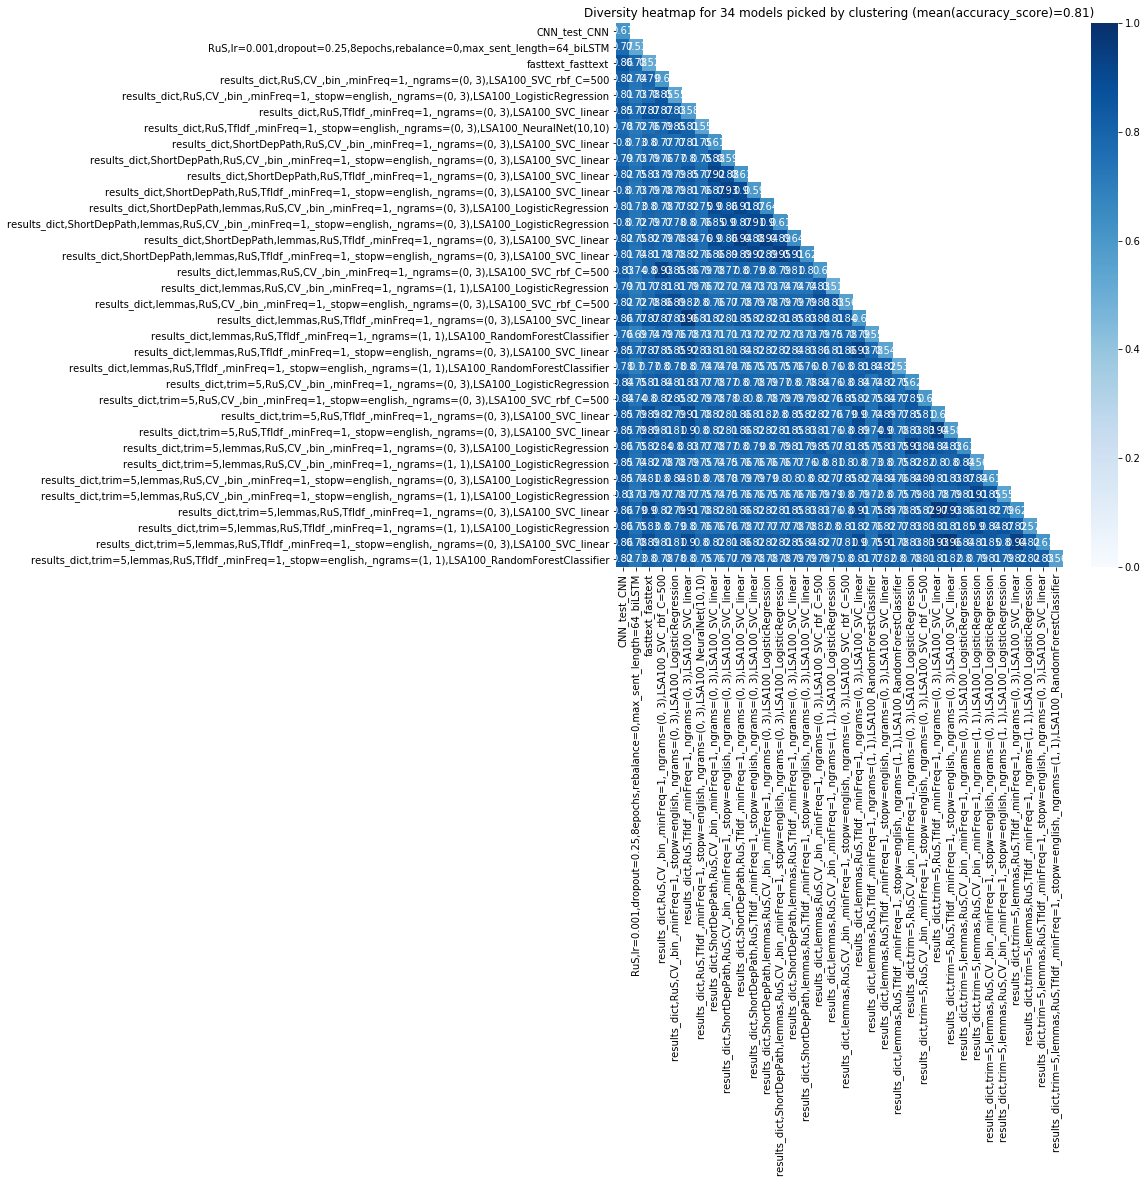

In [14]:
metric = accuracy_score

mean = diversity_matrix(results_dict,metric=accuracy_score).mean().mean()

diversity_heatmap(results_dict, 
                  metric=metric, diagonal_key='f1+', 
                  evaluate_on = "label_unlab_prob+",
                  title='Diversity heatmap for %i models picked by clustering (mean(%s)=%.2f)'%(
                      len(results_dict),metric.__name__, mean) )

In [15]:
# explore dict

# Clustering

In [16]:
# Load data

In [17]:
ml_models = results_dict.keys()

In [18]:
X = diversity_matrix(results_dict)

In [19]:
# Clustering directly with prediction matrix

# X = pd.DataFrame()
# for key in ml_models:
#     X[key] = pd.Series(results_dict[key]['label_val_binary'])

In [20]:
import seaborn as sns

In [21]:
n_clusters = 12

In [22]:
model = AgglomerativeClustering(n_clusters=n_clusters,
#                                 affinity=cohen_kappa_score,
#                                 linkage = 'average'
                               )
Z = model.fit_predict(X.T)

** Selection of 1 model out of cluster **

In [23]:
picked_models = []
cluster = {}
for i in range(n_clusters): #for each cluster
    mean_ck = {}
    print '\nCluster',i
    min_mean_ck=9999
    cluster[i] = []
    for j,m in enumerate(ml_models):
        if Z[j]==i:
            
            print ml_models[j]
            cluster[i].append(ml_models[j])
            models_not_in_cluster = [models for models in (set(ml_models)-set(cluster[i]))]
            X_outer_cluster = X.loc[models_not_in_cluster,:].mean()
            if min_mean_ck > X_outer_cluster[ml_models[j]]: #determine minimum mean cohens kappa value out of cluster
                min_mean_ck = X_outer_cluster[ml_models[j]]
                more_diverse_model = ml_models[j]
    
    # TODO: compute mean for those not in its own cluster
    print '\n****Picked model**** "%s" \n mean C.K.= %.2f'%(more_diverse_model,min_mean_ck )
    picked_models.append(more_diverse_model)

    
# picked_models.append('CNN_test_CNN')


Cluster 0
results_dict,trim=5,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear
results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear
results_dict,ShortDepPath,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_SVC_linear
results_dict,lemmas,RuS,CV_,bin_,minFreq=1,_ngrams=(1, 1),LSA100_LogisticRegression

****Picked model**** "results_dict,lemmas,RuS,CV_,bin_,minFreq=1,_ngrams=(1, 1),LSA100_LogisticRegression" 
 mean C.K.= 0.47

Cluster 1
results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression
results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression
results_dict,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_rbf_C=500

****Picked model**** "results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression" 
 mean C.K.= 0.54

Cluster 2
results_dict,lemmas,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_SVC_rbf_C=500
results_d

In [24]:
# diversity_heatmap(reduce_results_dict(results_dict,picked_models), metric=accuracy_score, diagonal_key='f1+', title='Diversity heatmap for 3 models picked by clustering (metric: accuracy)')

# Load cands to get tp,fp etc

In [25]:
with open("candidates_TrainValTestOutgoing.pickle", 'rb') as f:
    cand_dict = pickle.load(f)

In [26]:
# #get gold, pred lists from dicts for tp,fp etc
# ids = cand_dict[1].keys()

In [27]:
# classifier_name = 'RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM'

# classifier_dict = results_dict[classifier_name]

In [28]:
# y_val_pred = map(lambda x: 1 if results_dict[classifier_name]['label_val_prob+'][x]>=0.5 else -1, ids)

In [29]:
def get_tpfptnfn_cids(cand_dict, results_dict, classifier_name):
    """Get sets candidate ids of tp, fp, tn, fn"""
    
    ids = cand_dict[1].keys()
    y_val_gold = map(lambda x: cand_dict[1][x]['label'],ids)
    y_val_pred = map(lambda x: 1 if results_dict[classifier_name]['label_val_prob+'][x]>=0.5 else -1, ids)
    
    tp, fp,tn, fn= set(), set(), set(), set()
    for i, cid in enumerate(ids):
        true_lbl = y_val_gold[i]
        pred_lbl = y_val_pred[i]
#         print 'position', i, 'cid', cid, " | ",true_lbl,pred_lbl

    #     print cid
    #     print type(cid)
        if true_lbl==pred_lbl:
#             print 'correctly classified'
            if true_lbl==1:
#                 print 'true lbl==1'
                tp.add(cid)
            else:
                tn.add(cid)
        else:
            if true_lbl==1:
                fn.add(cid)
            else:
                fp.add(cid)
    return tp,fp,tn,fn


# Analysis - how many FN + FP over all our classifiers?

In [31]:
fp = {}
fn = {}
for model_name in picked_models:
    _, fp[model_name] , _, fn[model_name] = get_tpfptnfn_cids(cand_dict, results_dict, model_name)
    

In [41]:
# all common fp:
fps = [ fp[model_name] for model_name in picked_models]
print 'Always FPs: %i' %len(fps[0].intersection(*fps))


Always FPs: 26


In [42]:
# all common fn:
fns = [ fn[model_name] for model_name in picked_models]
print 'Always FNs: %i' %len(fns[0].intersection(*fns))


Always FNs: 19


# #TODO: new selection method (metric defined with David)


In [253]:
# step 1:calculate them again out of candidate dict

In [260]:
from itertools import  combinations

In [275]:
metrics = pd.DataFrame(columns=['metric1','metric2', 'metric3', 'metric4'])
for classifier_name1,classifier_name2 in combinations(picked_models, 2):
    
    tp1,fp1,tn1,fn1 = get_tpfptnfn_cids(cand_dict, results_dict, classifier_name1)
    tp2,fp2,tn2,fn2 = get_tpfptnfn_cids(cand_dict, results_dict, classifier_name2)
    
    print classifier_name1, '\n' , classifier_name2,'\n'
    ncTPs = len(tp1.difference(tp2))
    print 'Non-common TPs',ncTPs
    ncTNs = len(tn1.difference(tn2))
    print 'Non-common TNs',ncTNs
    
    ncFNs = len(fn1.difference(fn2))
    print 'Non-common FNs',ncFNs
    ncFPs = len(fp1.difference(fp2))
    print 'Non-common FPs',ncFPs

    total_mistakes = len(fp1)+len(fn1)+len(fp2)+len(fn2)
    print 'Total mistakes:', total_mistakes
    
    # Metric 1: Maximize non - common TP vs total mistakes made by both classifiers > 
    #     the second classifier could be  vote all positive
    metric1 = (float(ncTPs)/total_mistakes)
    print "************************"
    print "Metric 1:    |%.2f|"%metric1
    print "************************"
    
    # Metric 2: Maximize non - common TP+ non - common TN vs total mistakes made by both classifiers
    metric2 = (float(ncTPs+ncTNs)/total_mistakes)
    print "************************"
    print "Metric 2:    |%.2f|"%metric2
    print "************************"
    # Metric 3: Maximize non - common FP+ non - common FN vs total mistakes made by both classifiers
    metric3 = (float(ncFPs+ncFNs)/total_mistakes)
    print "************************"
    print "Metric 3:    |%.2f|"%metric3
    print "************************"
    # Metric 4: Maximize all non - common elmts vs total mistakes made by both classifiers
    metric4 = (float(ncFPs+ncFNs+ncTNs+ncTPs)/total_mistakes)
    print "************************"
    print "Metric 4:    |%.2f|"%metric4
    print "************************"
    
    comb_name = set((classifier_name1, classifier_name2))
#     comb_name = classifier_name1+' | '+classifier_name2
    
    metrics = metrics.append(
        pd.DataFrame({'metric1':metric1, 
                      'metric2': metric2,
                      'metric3': metric3,
                      'metric4': metric4,
                     }, index = [comb_name])
    )

results_dict,lemmas,RuS,CV_,bin_,minFreq=1,_ngrams=(1, 1),LSA100_LogisticRegression 
results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_LogisticRegression 

Non-common TPs 87
Non-common TNs 194
Non-common FNs 95
Non-common FPs 317
Total mistakes: 1715
************************
Metric 1:    |0.05|
************************
************************
Metric 2:    |0.16|
************************
************************
Metric 3:    |0.24|
************************
************************
Metric 4:    |0.40|
************************
results_dict,lemmas,RuS,CV_,bin_,minFreq=1,_ngrams=(1, 1),LSA100_LogisticRegression 
results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier 

Non-common TPs 68
Non-common TNs 250
Non-common FNs 114
Non-common FPs 284
Total mistakes: 1766
************************
Metric 1:    |0.04|
************************
************************
Metric 2:    |0.18|
************************
************************
Metric 3:   

Metric 2:    |0.31|
************************
************************
Metric 3:    |0.35|
************************
************************
Metric 4:    |0.66|
************************
results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier 
results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(1, 1),LSA100_LogisticRegression 

Non-common TPs 112
Non-common TNs 276
Non-common FNs 96
Non-common FPs 301
Total mistakes: 1677
************************
Metric 1:    |0.07|
************************
************************
Metric 2:    |0.23|
************************
************************
Metric 3:    |0.24|
************************
************************
Metric 4:    |0.47|
************************
results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier 
results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear 

Non-common TPs 110
Non-common TNs 221
Non-common FNs 98
Non-common FPs 42

RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM 
results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_SVC_linear 

Non-common TPs 151
Non-common TNs 103
Non-common FNs 77
Non-common FPs 417
Total mistakes: 1316
************************
Metric 1:    |0.11|
************************
************************
Metric 2:    |0.19|
************************
************************
Metric 3:    |0.38|
************************
************************
Metric 4:    |0.57|
************************
RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM 
results_dict,lemmas,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(1, 1),LSA100_RandomForestClassifier 

Non-common TPs 107
Non-common TNs 451
Non-common FNs 153
Non-common FPs 308
Total mistakes: 1653
************************
Metric 1:    |0.06|
************************
************************
Metric 2:    |0.34|
************************
************************
Metric 3:    |0.28|
**

In [304]:
metrics.sort_values('metric4',ascending=False)

,metric1,metric2,metric3,metric4
"{RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM, results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier}",0.112893,0.307835,0.347933,0.655768
"{results_dict,ShortDepPath,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear, RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM}",0.079342,0.266619,0.378842,0.645461
"{results_dict,lemmas,RuS,CV_,bin_,minFreq=1,_ngrams=(1, 1),LSA100_LogisticRegression, RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM}",0.084656,0.265726,0.350970,0.616696
"{RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM, results_dict,lemmas,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(1, 1),LSA100_RandomForestClassifier}",0.064731,0.337568,0.278887,0.616455
"{results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear, RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM}",0.062762,0.264993,0.350070,0.615063
"{fasttext_fasttext, results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier}",0.171153,0.222222,0.385783,0.608006
"{results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(1, 1),LSA100_LogisticRegression, RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM}",0.056452,0.319479,0.284739,0.604218
"{results_dict,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_NeuralNet(10,10), RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM}",0.066838,0.300771,0.300771,0.601542
"{results_dict,trim=5,lemmas,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(1, 1),LSA100_RandomForestClassifier, RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM}",0.088501,0.302972,0.297804,0.600775
"{results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_SVC_linear, results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier}",0.151340,0.189718,0.410572,0.600290


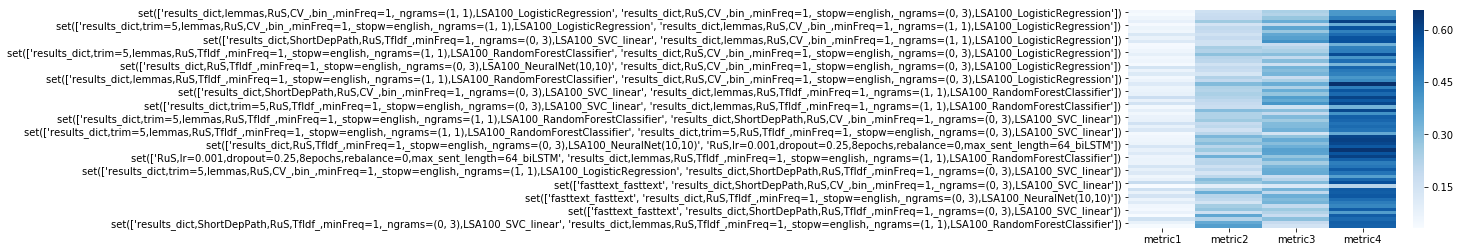

In [277]:
sns.heatmap(metrics,cmap='Blues')

In [317]:
num_class=8 #must be even number
picked_classif = set()
# pick the 1st pair
# sorted_list = metrics.sort_values('metric4',ascending=False).index
picked_classif.update(metrics.sort_values('metric4',ascending=False).index[0])
for i in range(1,len(metrics)):
    possible_set = metrics.sort_values('metric4',ascending=False).index[i]
    if len(picked_classif.intersection(possible_set))==0:
        #add those two in the stack too
        picked_classif.update(possible_set)
        if len(picked_classif)>=num_class: #limit the # of classifiers which are picked
            break

In [318]:
picked_classif

{'RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM',
 'fasttext_fasttext',
 'results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,ShortDepPath,RuS,TfIdf_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,lemmas,RuS,CV_,bin_,minFreq=1,_ngrams=(1, 1),LSA100_LogisticRegression',
 'results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier',
 'results_dict,trim=5,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100_SVC_linear',
 'results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(1, 1),LSA100_LogisticRegression'}

In [312]:
# diversity_heatmap(reduce_results_dict(results_dict,picked_models), 
#                   metric=accuracy_score, diagonal_key='f1+', 
#                   evaluate_on = "label_val_prob+",
#                   title='Diversity heatmap for 3 models picked by clustering (metric: accuracy)', )

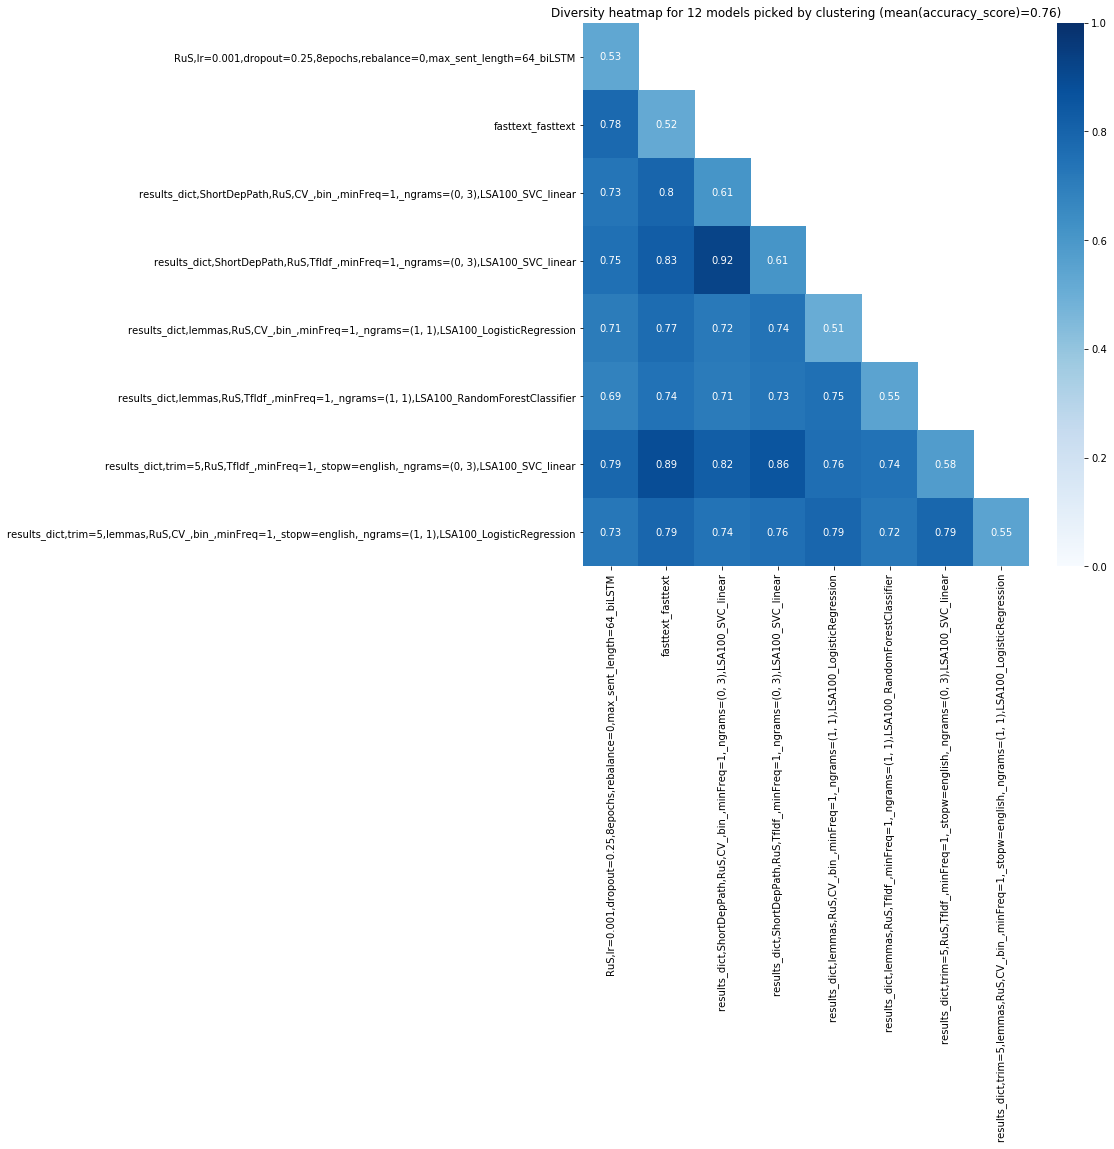

In [319]:
metric = accuracy_score

mean = diversity_matrix(
    reduce_results_dict(results_dict,picked_classif),
    metric=accuracy_score,
    diagonal_key=None
).mean().mean()

diversity_heatmap(reduce_results_dict(results_dict,picked_classif), 
                  metric=metric, diagonal_key='f1+', 
                  evaluate_on = "label_unlab_prob+",
                  title='Diversity heatmap for %i models picked by clustering (mean(%s)=%.2f)'%(
                      len(picked_models),metric.__name__, mean) )

In [314]:
selected_class_dict = reduce_results_dict(results_dict,picked_classif)

In [315]:
selected_class_dict.keys()

['fasttext_fasttext',
 'results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear',
 'RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM',
 'results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier']

In [316]:
for name in selected_class_dict.keys():
    print name
    print results_dict[name]['classification_report']

fasttext_fasttext
           precision  recall  f1-score  support
Classes                                        
-1              0.86    0.91      0.88     2525
1               0.59    0.46      0.52      705
avg/total       0.80    0.81      0.80     3230
results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear
           precision  recall  f1-score  support
Classes                                        
-1              0.91    0.82      0.86     2525
1               0.53    0.72      0.61      705
avg/total       0.83    0.80      0.81     3230
RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM
           precision  recall  f1-score  support
Classes                                        
-1              0.89    0.79      0.84     2525
1               0.46    0.63      0.53      705
avg/total       0.79    0.76      0.77     3230
results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier
           precision  

In [300]:
with open('ml_predictions/4models_selection_metric4.pickle' ,'wb') as f:
    pickle.dump(selected_class_dict,f)

In [42]:
# for i,m in enumerate(ml_models):
#     print Z[i], '\t', m
#     # for each cluster, pick model with lowest 

# ~

## Dendrogram

In [73]:
from scipy.cluster import hierarchy

In [74]:
dn = hierarchy.dendrogram(Z)

TypeError: Linkage matrix 'Z' must contain doubles.

In [70]:
model.n_clusters

5

In [68]:
X

,"results_dict,lemmas,RuS,CV_,bin_,minFreq=3,_stopw=english_LogisticRegression","results_dict,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,ShortDepPath,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_LogisticRegression","results_dict,RuS,TfIdf_,minFreq=3,_stopw=english_SVC_rbf_C=500","results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3)_LogisticRegression","results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,trim=0,RuS,TfIdf_,minFreq=3,_stopw=english_SVC_rbf_C=500","results_dict,trim=0,lemmas,RuS,TfIdf_,minFreq=3,_stopw=english_LogisticRegression","results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(2, 2)_LogisticRegression","RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,max_sent_length=64_biLSTM",...,"results_dict,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_LogisticRegression","results_dict,trim=0,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,lemmas,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,trim=5,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,trim=5,RuS,TfIdf_,minFreq=3,_stopw=english,LSA100_LogisticRegression","results_dict,trim=0,lemmas,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500","results_dict,lemmas,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_linear","results_dict,trim=5,RuS,CV_,bin_,minFreq=3,_stopw=english_SVC_rbf_C=500","results_dict,ShortDepPath,RuS,TfIdf_,minFreq=3,_stopw=english_LogisticRegression","results_dict,trim=0,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_RandomForestClassifier"
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,1,-1,1,1,-1,-1,-1,1,-1,...,1,-1,1,-1,-1,-1,1,1,-1,-1
4,-1,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
6,-1,-1,-1,-1,-1,-1,1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9,1,-1,1,-1,1,1,1,1,1,-1,...,-1,1,1,1,1,1,1,1,1,1


In [65]:
import matplotlib.pyplot as plt
import numpy as np

In [66]:
model.labels_

array([2, 2, 4, 2, 0, 1, 3, 3, 0, 0, 2, 1, 4, 3, 1, 0, 1, 4, 1, 3, 0, 2,
       3, 2, 3, 2, 1, 1, 3, 2, 1, 4, 3])

NameError: name 'metric' is not defined

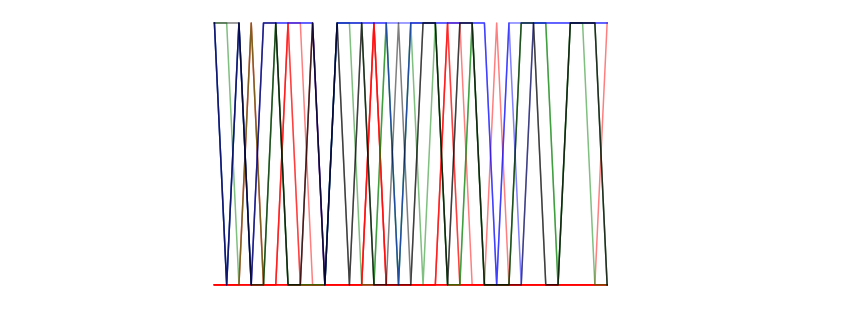

In [58]:
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
    plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
plt.axis('tight')
plt.axis('off')
plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)
plt.show()

In [ ]:
model = AgglomerativeClustering(n_clusters=n_clusters,
                                affinity=cohen_kappa_score)
model.fit(X)
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
    plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
plt.axis('tight')
plt.axis('off')
plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)
